## Importing Libraries

In [1]:
!pip install tensorflow

In [2]:
!pip install pydot
!pip install graphviz

## Importing Libraries

In [3]:
import os
import random
# for data preprocessing
import numpy as np
from sklearn.utils import shuffle
# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from PIL import ImageEnhance, Image

from tqdm import tqdm



## Reading the dataset

In [4]:
Train_dir = "BrainTumorDataset/Training/"
Test_dir = "BrainTumorDataset/Testing/"
train_paths = [ ]
train_labels = [ ]
for label in os.listdir(Train_dir):
    for image in os.listdir(Train_dir+label):
        train_paths.append(Train_dir+label+'/'+image)
        train_labels.append(label)
        
train_paths,train_labels=shuffle(train_paths,train_labels)

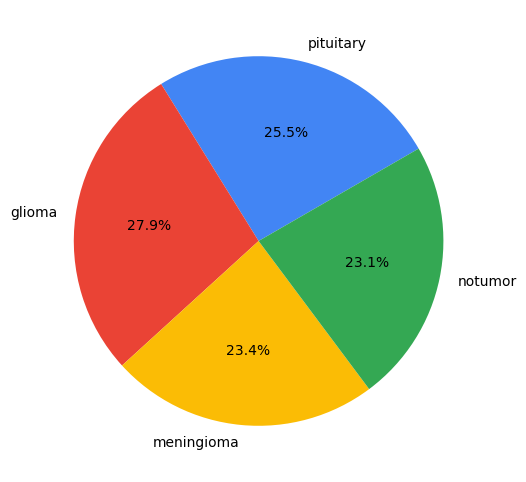

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.pie([len([x for x in train_labels if x=="pituitary"]),
        len ([x for x in train_labels if x=="notumor"]),
        len ([x for x in train_labels if x=="meningioma"]),
        len ([x for x in train_labels if x=="glioma"])],
        labels=["pituitary","glioma","meningioma","notumor"],
        colors=colors,autopct="%.1f%%",startangle=30);

In [6]:
test_paths = [ ]
test_labels = [ ]
for label in os.listdir(Test_dir):
    for image in os.listdir(Test_dir+label):
        test_paths.append(Test_dir+label+'/'+image)
        test_labels.append(label)

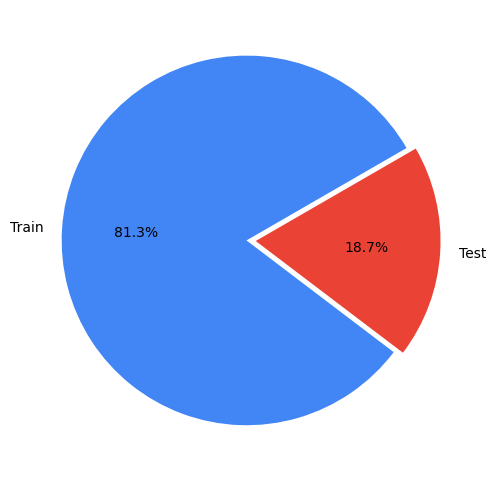

In [7]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.pie([len(train_labels),len(test_labels)],
         labels=["Train","Test"],
        colors=colors,autopct="%.1f%%",startangle=30,explode=(0.05,0));

## Data Augmentation

In [8]:
def Augment_Image(image):
    image= Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image=np.array(image)/255.0
    return image

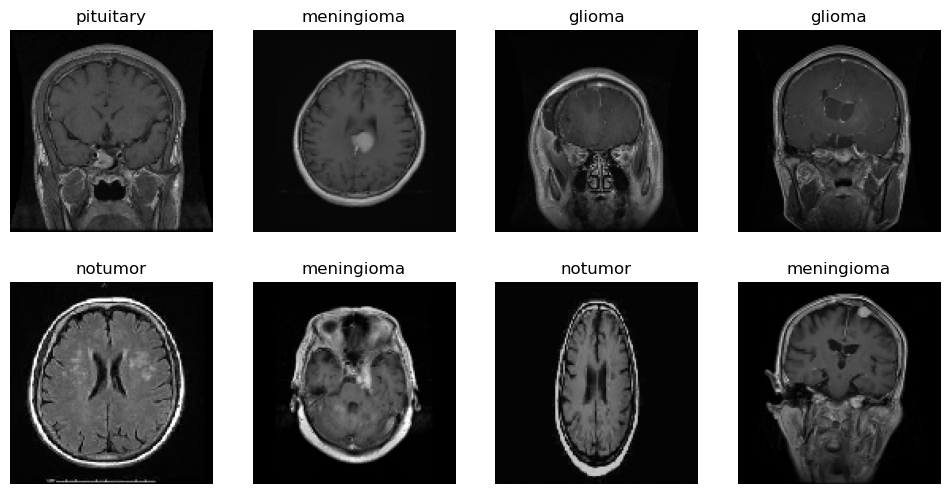

In [9]:
IMAGE_SIZE=128

def open_image(paths):
    images=[]
    for path in paths:
        image=load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image= Augment_Image(image)
        images.append(image)
    return np.array(images)
images= open_image(train_paths[50:59])
labels=train_labels[50:59]
fig=plt.figure(figsize=(12,6))
for x in range (1,9):
    fig.add_subplot(2,4,x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Data Generator

In [21]:
unique_labels = os.listdir(Train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_image(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## Modeling 
#### TransferLearning VGG16

In [22]:
model_base=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
for layer in model_base.layers:
    layer.trainable=False
#entrainer les derniers couches 
model_base.layers[-2].trainable=True
model_base.layers[-3].trainable=True    
model_base.layers[-4].trainable=True    
 
model= Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(model_base)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

## Train model

In [25]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 663s 2s/step - loss: 0.4497 - sparse_categorical_accuracy: 0.8274
Epoch 2/4
285/285 [==============================] - 624s 2s/step - loss: 0.2337 - sparse_categorical_accuracy: 0.9160
Epoch 3/4
285/285 [==============================] - 603s 2s/step - loss: 0.1543 - sparse_categorical_accuracy: 0.9411
Epoch 4/4
285/285 [==============================] - 626s 2s/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9615


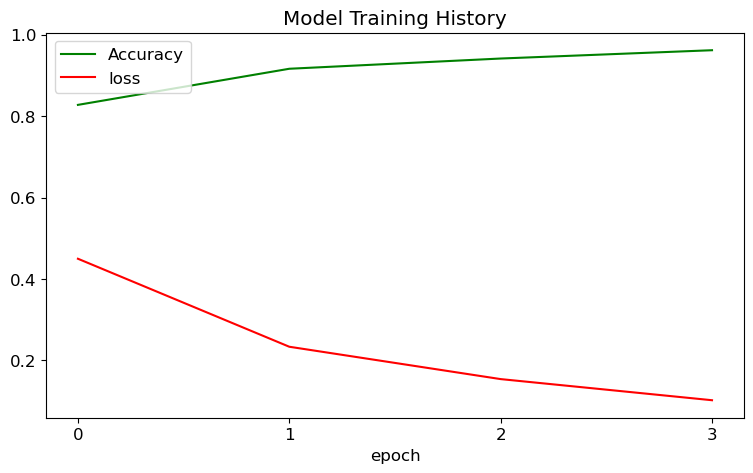

In [31]:
plt.figure(figsize=(9,5))
plt.plot(history.history['sparse_categorical_accuracy'], 'g-')
plt.plot(history.history['loss'], 'r-')
plt.xlabel("epoch")
plt.title("Model Training History")
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy',"loss"],loc="upper left")
plt.show()

Our loss is decreasing when the number of epoch decrease

## Evaluate model

In [43]:
batch_size=32
steps = int(len(test_paths)/batch_size)
y_pred=[]
y_true=[]
for x,y in tqdm(datagen(test_paths,test_labels,batch_size=32),disable=True,total=steps):
          pred=model.predict(x)
          pred=np.argmax(pred,axis=1)
          for i in decode_label(pred):
                y_pred.append(i)
          for i in decode_label(y):
              y_true.append(i)

1/1 [==============================] - 3s 3s/step


In [44]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

      glioma       0.96      0.87      0.92       300
  meningioma       0.91      0.80      0.85       306
     notumor       0.93      1.00      0.96       405
   pituitary       0.88      0.99      0.93       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.92      1311
weighted avg       0.92      0.92      0.92      1311

